In [29]:
"""
Section 1 Import Libraries
"""

import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

print("...")

...


...
Original Image


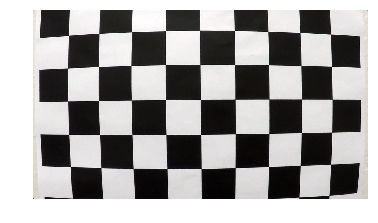

Undistorted Image


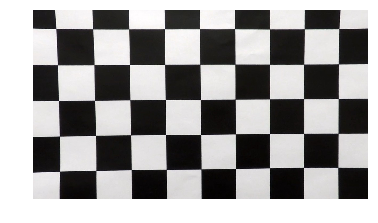

Original Image


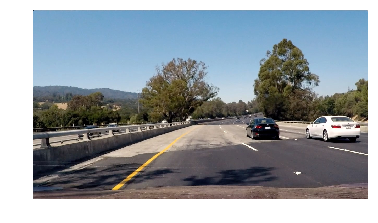

Undistorted Image


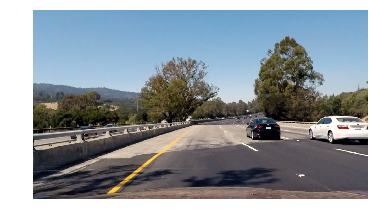

In [30]:
"""
Section 2

Contains 2 functions:
1) Calibrate Camera and 2) Undistort Image
"""

def calibrate_camera():
    try:
        #if calibration data exists read file, else recreate calibration_data file
        data = pickle.load(open('camera_cal/calibration_data.pkl', 'rb'))
        mtx = data[0]
        dist = data[1]
    except:
        objpoints = []
        imgpoints = []
        objp = np.zeros((6*9,3), np.float32) # looking for 6 & 9 inner corners
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 
        cali_img = 0
        for i in range (1,21):
            cal_img_name = 'camera_cal/calibration'+str(i)+'.jpg'
            cal_img = cv2.imread(cal_img_name,1)
            cal_img_gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(cal_img_gray, (9,6),None)
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
                cali_img += 1
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_img_gray.shape[::-1],None,None)
        data = [mtx,dist]
        pickle.dump(data, open('camera_cal/calibration_data.pkl', 'wb'))
    return mtx, dist

mtx, dist = calibrate_camera()

def undistort(image, mtx, dist):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_img

print("...")

"""
Visualize Distortion Correction
"""
for image in glob.glob("./camera_cal/calibration1.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    print("Original Image")
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print("Undistorted Image")
    plt.imshow(undistort_img)
    plt.axis("off")
    plt.show()
    
for image in glob.glob("./test_images/*4.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    print("Original Image")
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    print("Undistorted Image")
    plt.imshow(undistort_img)
    plt.axis("off")
    plt.show()  

...


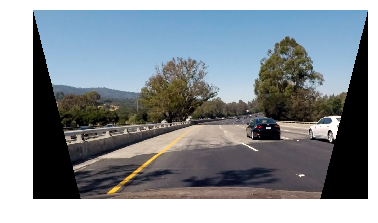

In [31]:
"""

Section 3

Applies an image mask.
This helps in removing some unwanted features and noise

"""  

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("...")

"""
Visualize region_of_interest mask
"""

for image in glob.glob("./test_images/*4.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    masked_img = region_of_interest(undistort_img)
    plt.imshow(masked_img)
    plt.axis("off")
    plt.show()

...
Thresholded Image


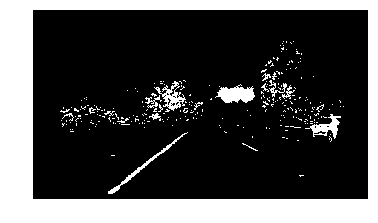

In [32]:
"""
Section 4

Thresholding

"""
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.2)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #Take the absolute value of the x and y gradients
    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_threshold(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    # Return this mask as your binary_output image
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def combined_thresholding_pipeline(img):

    #Apply White and Yellow Mask and combine 
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    ## Apply White Color Masking
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Apply Yellow Color Masking
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
    combined_binary[(combined_binary == 255)] = 1
    return combined_binary

print("...")


"""
Visualize Thresholded Image
"""

for image in glob.glob("./test_images/*4.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    masked_img = region_of_interest(undistort_img)
    combined = combined_thresholding_pipeline(masked_img)
    #calculate_perspective_matrices(combined)
    #M,Minv = load_perspective_matrices()
    #binary_warped = perspective_transform(combined)
    #result=lane_detection(binary_warped,Minv)
    print("Thresholded Image")
    plt.imshow(combined,cmap="gray")
    plt.axis("off")
    plt.show()

...
Original Undistorted Image


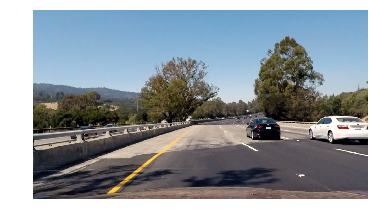

Perspective Transformed


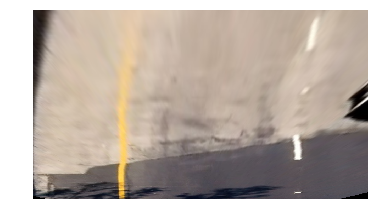

Perspective Transformed Binary Image


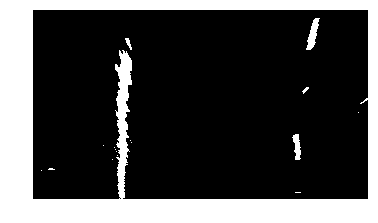

In [33]:
"""
Section 5

Perspective transform
"""

def calculate_perspective_matrices(img, src=None, dst=None):
    """
    Performs a perspective transformation on given image
    Inputs:
    - img : Undistorted image
    Outputs:
    - Transformed image
    """
    im_shape = (img.shape[1], img.shape[0])
    if src is None and dst is None:
        #src = np.float32([[293, 668], [587, 458], [703, 458], [1028, 668]])
        src = np.float32([[295, 670], [588, 458], [702, 458], [1028, 670]])
        dst = np.float32([[310, im_shape[1]], [310, 0],
                          [950, 0], [950, im_shape[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    pickle.dump([M, Minv], open('./perspective_transform.p', 'wb'))


def load_perspective_matrices():
    M, Minv = pickle.load(open('./perspective_transform.p', 'rb'))
    return M, Minv


def perspective_transform(img):
    """
    Performs a perspective transformation on given image
    Inputs:
    - img : Undistorted image
    - M : Transformation matrix
    Outputs:
    - Transformed image
    """
    calculate_perspective_matrices(img)
    im_shape = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, im_shape)

print("...")

M,Minv = load_perspective_matrices()


"""
Visualize perspective transform
"""
for image in glob.glob("./test_images/*4.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    masked_img = region_of_interest(undistort_img)
    combined = combined_thresholding_pipeline(masked_img)
    calculate_perspective_matrices(combined)
    M,Minv = load_perspective_matrices()
    
    print("Original Undistorted Image")
    plt.imshow(undistort_img)
    plt.axis("off")
    plt.show()
    
    print("Perspective Transformed")
    warped = perspective_transform(undistort_img)
    plt.imshow(warped)
    plt.axis("off")
    plt.show()
    
    print("Perspective Transformed Binary Image")
    binary_warped = perspective_transform(combined)
    plt.imshow(binary_warped,cmap="gray")
    plt.axis("off")
    plt.show()

In [34]:
"""
Section 6

Lane Detection
"""

def lane_detection(image,Minv):
    
    """
    part1
    """
    binary_warped = image
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    """
    Part 2 Visualize
    """
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([leftx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([rightx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    
    """
    Part 3 Adjust to meters
    """
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    #curvature = (left_curverad + right_curverad)/2
    
    """
    Part 4 
    
    Estimate Curvature and offset
    """    
    
    curvature = (left_curverad + right_curverad)/2
    
    offset =((rightx_base-640 )-(640-leftx_base))*xm_per_pix
    
    
    
    """
    Part 5 
    
    Return Final Resuls with lane drawn out
    """
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
    #cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    #cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 2, (255, 255, 255), 2)
    #cv2.putText(result, 'Midpoint = %d(m)' % lane_lines_midpoint, (50, 100), font, 2, (255, 255, 255), 2)
    left_or_right = 'left' if offset < 0 else 'right'
    cv2.putText(result, 'Vehicle is %.2fm %s of center' % (np.abs(offset), left_or_right), (50, 150), font, 2,(255, 255, 255), 2)
    #cv2.putText(result, 'Vehicle is %.1f of center' % offset, (50, 100), font, 1,(255, 255, 255), 2)
    return result

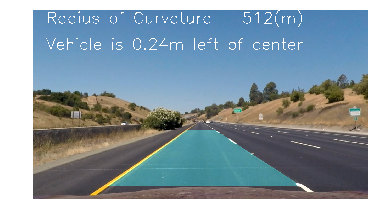

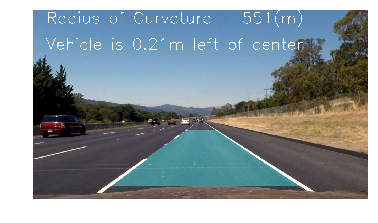

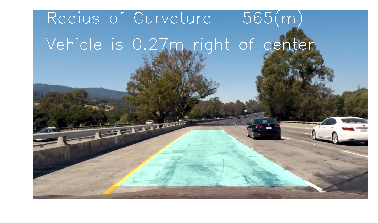

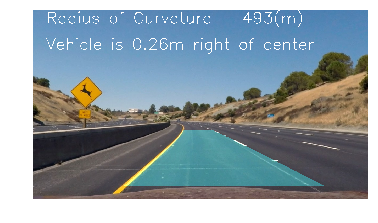

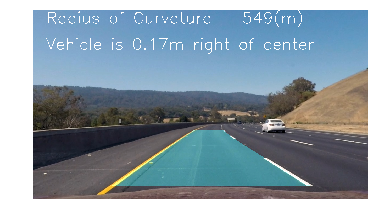

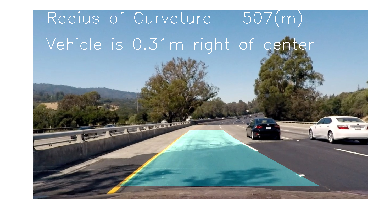

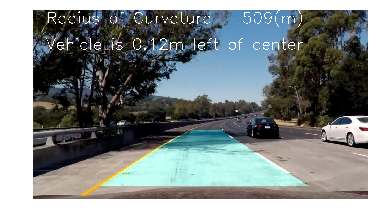

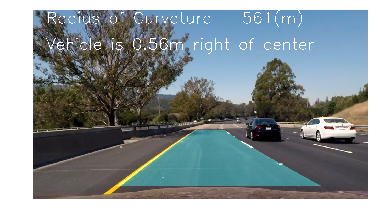

In [35]:
"""
Section 7

Visualize Lane Detection
"""

for image in glob.glob("./test_images/*.jpg"):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    masked_img = region_of_interest(undistort_img)
    combined = combined_thresholding_pipeline(masked_img)
    calculate_perspective_matrices(combined)
    #M,Minv = load_perspective_matrices()
    binary_warped = perspective_transform(combined)
    result=lane_detection(binary_warped,Minv)
    plt.imshow(result)
    plt.axis("off")
    plt.show()
    

In [36]:
"""

Section 8

Video Pipeline below
"""

def pipeline(img):
    """
    writes frames into "project_video_submission_temp" directory
    """
    undistort_img = undistort(img, mtx, dist)
    return undistort_img

def process_image(img):
    result = pipeline(img)
    return result

In [37]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_images_sequence('project_video_submission_temp/frame%05d.jpeg', fps=30)

  self.nchannels))



[MoviePy] Writing frames project_video_submission_temp/frame%05d.jpeg.

1512it [01:39, 15.33it/s]                                                                                              


[MoviePy]: Done writing frames project_video_submission_temp/frame%05d.jpeg.

Wall time: 1min 39s


['project_video_submission_temp/frame00000.jpeg',
 'project_video_submission_temp/frame00001.jpeg',
 'project_video_submission_temp/frame00002.jpeg',
 'project_video_submission_temp/frame00003.jpeg',
 'project_video_submission_temp/frame00004.jpeg',
 'project_video_submission_temp/frame00005.jpeg',
 'project_video_submission_temp/frame00006.jpeg',
 'project_video_submission_temp/frame00007.jpeg',
 'project_video_submission_temp/frame00008.jpeg',
 'project_video_submission_temp/frame00009.jpeg',
 'project_video_submission_temp/frame00010.jpeg',
 'project_video_submission_temp/frame00011.jpeg',
 'project_video_submission_temp/frame00012.jpeg',
 'project_video_submission_temp/frame00013.jpeg',
 'project_video_submission_temp/frame00014.jpeg',
 'project_video_submission_temp/frame00015.jpeg',
 'project_video_submission_temp/frame00016.jpeg',
 'project_video_submission_temp/frame00017.jpeg',
 'project_video_submission_temp/frame00018.jpeg',
 'project_video_submission_temp/frame00019.jpeg',


In [38]:
"""
runs image processing on the frames in "project_video_submission_temp" directory
and writes processed frames into project_video_submission directory
"""

for image in glob.glob("./project_video_submission_temp/*.jpeg"):
    name_string=image.split("\\")
    final_name_string="./project_video_submission/a"+name_string[1]
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(img_rgb, mtx, dist)
    masked_img = region_of_interest(undistort_img)
    combined = combined_thresholding_pipeline(masked_img)
    calculate_perspective_matrices(combined)
    binary_warped = perspective_transform(combined)
    result=lane_detection(binary_warped,Minv)
    final_result=cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite(final_name_string,final_result)
    print("writing ... "+final_name_string)

print("images processed and ready")

writing ... ./project_video_submission/aframe00000.jpeg
writing ... ./project_video_submission/aframe00001.jpeg
writing ... ./project_video_submission/aframe00002.jpeg
writing ... ./project_video_submission/aframe00003.jpeg
writing ... ./project_video_submission/aframe00004.jpeg
writing ... ./project_video_submission/aframe00005.jpeg
writing ... ./project_video_submission/aframe00006.jpeg
writing ... ./project_video_submission/aframe00007.jpeg
writing ... ./project_video_submission/aframe00008.jpeg
writing ... ./project_video_submission/aframe00009.jpeg
writing ... ./project_video_submission/aframe00010.jpeg
writing ... ./project_video_submission/aframe00011.jpeg
writing ... ./project_video_submission/aframe00012.jpeg
writing ... ./project_video_submission/aframe00013.jpeg
writing ... ./project_video_submission/aframe00014.jpeg
writing ... ./project_video_submission/aframe00015.jpeg
writing ... ./project_video_submission/aframe00016.jpeg
writing ... ./project_video_submission/aframe000

In [ ]:
"""
This concatenates the frames in the project_video_submission directory into 
a new video file named project_video_submission.mp4

video.py file from Project 3 contains the following Code 
to use: please run "python video.py project_video_submission --fps 30" from the main directory which has the video.py file

"""
#Reuse this technique from project 3
#The reason for this longer way is because I am on an old computer which sometimes runs out of memory running moviepy jobs
#On a lighter note this is a good example of software reuse! 
#:)

"""
from moviepy.editor import ImageSequenceClip
import argparse


def main():
    parser = argparse.ArgumentParser(description='Create driving video.')
    parser.add_argument(
        'image_folder',
        type=str,
        default='',
        help='Path to image folder. The video will be created from these images.'
    )
    parser.add_argument(
        '--fps',
        type=int,
        default=60,
        help='FPS (Frames per second) setting for the video.')
    args = parser.parse_args()

    video_file = args.image_folder + '.mp4'
    print("Creating video {}, FPS={}".format(video_file, args.fps))
    clip = ImageSequenceClip(args.image_folder, fps=args.fps)
    clip.write_videofile(video_file)


if __name__ == '__main__':
    main()
"""

